In [ ]:
import torch, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from torch import nn
from itertools import product
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/Digit/Data/train.csv', dtype=np.float32)
test = pd.read_csv('/content/drive/MyDrive/Kaggle/Digit/Data/test.csv', dtype=np.float32)

# reading data
train_features = train.loc[:, train.columns != 'label'].values/255 # normalizing data
train_targets = train.label.values
test_features = test.values/255

# spliting into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_targets, test_size=0.25, random_state=44
)

# converting to tensors
X_train, X_val, y_train, y_val, X_test = (
    torch.from_numpy(x).float() for x in [X_train, X_val, y_train, y_val, test_features]
)
y_train = y_train.long()
y_val = y_val.long()


X_train[:5]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

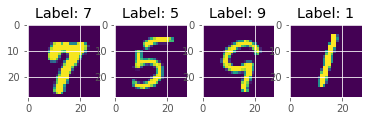

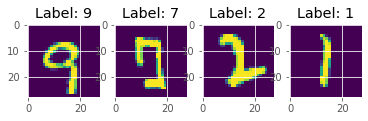

In [ ]:
fig, axes = plt.subplots(1,4)
axes = iter(axes.reshape(-1))
for i, ax in zip(range(4), axes):
    current_image = X_train[i].reshape(28,28)
    ax.imshow(current_image, interpolation='nearest')
    ax.set_title(f'Label: {y_train[i].item()}')

fig, axes = plt.subplots(1,4)
axes = iter(axes.reshape(-1))
for i, ax in zip(range(4), axes):
    current_image = X_val[i].reshape(28,28)
    ax.imshow(current_image, interpolation='nearest')
    ax.set_title(f'Label: {y_val[i].item()}')

## Defining a few network architectures
### BasicNet
- a three fully connected layers with ReLU activation
- I don't know if it's correct to put softmax in the end

### RegularizedComplextNet
- arbritraly injected more layers but with droputs this time
- todo: understand why this net did not converge

### LeNet
- classic deep architecture

In [ ]:
# defining a very basic net architecture
class BasicNet(nn.Module):
    def __init__(self, net=None):
        super(BasicNet, self).__init__()
        if net is None:
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(28*28, 28*28*2),
                nn.ReLU(),
                nn.Linear(28*28*2, 10),
                nn.Softmax(1)
            )
        else:
            self.net = net
    
    def forward(self, x):
        return self.net(x)

class RegularizedComplexNet(nn.Module):
    def __init__(self, net=None):
        super(RegularizedComplexNet, self).__init__()
        if net is None:
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(28*28, 28*28*2),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(28*28*2, 28*28*4),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(28*28*4, 28*28*2),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(28*28*2, 28*28),
                nn.ReLU(),
                nn.Linear(28*28, 10),
                nn.Softmax(1)
            )
        else:
            self.net = net
    
    def forward(self, x):
        return self.net(x)

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
        nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10), nn.Softmax(1)
      )
  
  def forward(self, x):
    x = x.reshape((x.shape[0], 1, 28, 28))
    output = self.net(x)
    return output


In [ ]:
# method for initing weights on linear layers    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)     
        
# converting train/val data into iterable objects using DataLoader
def get_dataiter(batch_size=128):
    train = torch.utils.data.TensorDataset(X_train, y_train)
    val = torch.utils.data.TensorDataset(X_val, y_val)

    train = DataLoader(train, batch_size=batch_size, shuffle=False)
    val = DataLoader(val, batch_size=batch_size, shuffle=False)
    return train, val

def train_epoch(net, train_iter, loss_fn, updater):
    net.train()
    train_loss = 0
    train_acc = 0
    correct = 0
    for n_batch, (X, y) in enumerate(train_iter):
        X, y = X.to(device), y.to(device)
        y_pred = net(X) # making predictions
        updater.zero_grad() # reseting gradients
        loss = loss_fn(y_pred, y)
        loss.backward() # calculating gradients
        updater.step() # updating gradients

        # train_loss += loss_fn(y_pred, y, reduction='sum').item()
        train_loss += float(loss)
        pred = y_pred.cpu().argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(y.cpu().view_as(pred)).sum().item()
        # train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(1))
    train_acc = 100. * correct / len(train_iter.dataset)
    train_loss /= len(train_iter.dataset)
    return train_acc, train_loss

def val_epoch(net, val_iter, loss_fn):
    val_loss = 0
    val_acc = 0
    correct = 0
    net.eval()
    with torch.no_grad():
        for n_batch, (X, y) in enumerate(val_iter):
            X, y = X.to(device), y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y)
            val_loss += float(loss)
            # val_acc = accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
            pred = y_pred.cpu().argmax(dim=1, keepdim=True)
            correct += pred.eq(y.cpu().view_as(pred)).sum().item()

    return 100. * correct / len(val_iter.dataset), val_loss / len(val_iter.dataset)

def training(net, train_iter, val_iter, loss_fn, updater, n_epochs):
    # training
    scores = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    for epoch in range(n_epochs):
        train_acc, train_loss = train_epoch(net, train_iter, loss_fn, updater)
        val_acc, val_loss = val_epoch(net, val_iter, loss_fn)
        scores['train_acc'].append(train_acc)
        scores['train_loss'].append(train_loss)
        scores['val_acc'].append(val_acc)
        scores['val_loss'].append(val_loss)
    return scores

I initially performed a grid search for model selection, and the following hyperparameters were selected; for weight decay only one value was considered during the whole experiment

In [ ]:
lr = [0.01, 0.05, 0.1]
batch_size = [32, 64, 128, 256]
num_epochs = [50, 100]
weight_decay=[0.001, 0.01]
nets = {'BasicNet': BasicNet, 'RegularizedComplexNet': RegularizedComplexNet, 'LeNet': LeNet}
params = product(num_epochs, batch_size, lr, weight_decay, nets)
results = pd.DataFrame()
# results = pd.read_csv('/content/drive/MyDrive/Kaggle/Digit/results.csv', index_col=0)

for n, bs, lr, wd, net_arch in params:
    print(f'Evaluating {net_arch} n_epochs={n}, batch_size={bs}, lr={lr}, and wd={wd}.')
    
    net = nets[net_arch]().to(device)
    net.apply(init_weights)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    updater = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
    train, val = get_dataiter(bs)
    
    start = time.time()
    scores = training(net, train, val, loss_fn, updater, n)
    elapsed_time = time.time() - start
    scores = pd.DataFrame(scores)
    scores['elapsed_time'] = elapsed_time
    scores['cuda'] = 'yes'
    scores['net'] = net
    scores[['n_epochs', 'batch_size', 'lr']] = n, bs, lr
    results = pd.concat([results, pd.DataFrame(scores)])
    results.to_csv('/content/drive/MyDrive/Kaggle/Digit/results.csv')

Evaluating BasicNet n_epochs=50, batch_size=32, lr=0.01, and wd=0.001.
Evaluating RegularizedComplexNet n_epochs=50, batch_size=32, lr=0.01, and wd=0.001.
Evaluating LeNet n_epochs=50, batch_size=32, lr=0.01, and wd=0.001.
Evaluating BasicNet n_epochs=50, batch_size=32, lr=0.01, and wd=0.01.
Evaluating RegularizedComplexNet n_epochs=50, batch_size=32, lr=0.01, and wd=0.01.
Evaluating LeNet n_epochs=50, batch_size=32, lr=0.01, and wd=0.01.
Evaluating BasicNet n_epochs=50, batch_size=32, lr=0.05, and wd=0.001.
Evaluating RegularizedComplexNet n_epochs=50, batch_size=32, lr=0.05, and wd=0.001.
Evaluating LeNet n_epochs=50, batch_size=32, lr=0.05, and wd=0.001.
Evaluating BasicNet n_epochs=50, batch_size=32, lr=0.05, and wd=0.01.
Evaluating RegularizedComplexNet n_epochs=50, batch_size=32, lr=0.05, and wd=0.01.
Evaluating LeNet n_epochs=50, batch_size=32, lr=0.05, and wd=0.01.
Evaluating BasicNet n_epochs=50, batch_size=32, lr=0.1, and wd=0.001.
Evaluating RegularizedComplexNet n_epochs=50

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Kaggle/Digit/results.csv', index_col=0)
results.reset_index(inplace=True)
results = results.rename(columns={'index': 'epoch'})

results['net'] = results['net'].apply(lambda x: x.split('(')[0])
results['net'].unique()
results['epoch'] += 1
results['val_acc'] /= 100
results['train_acc'] /= 100
results['NetArch'] = results['net'] + '_n=' + results['n_epochs'].astype(str) + '_bs=' + results['batch_size'].astype(str) + '_lr=' + results['lr'].astype(str)
results.drop_duplicates(['net', 'epoch', 'n_epochs', 'batch_size', 'lr'], inplace=True) # weight decay = 0.001 only
results

,epoch,train_acc,train_loss,val_acc,val_loss,elapsed_time,cuda,net,n_epochs,batch_size,lr,NetArch
0,1,0.771175,1.721447,0.898476,1.582537,114.257063,yes,BasicNet,50,32,0.01,BasicNet_n=50_bs=32_lr=0.01
1,2,0.914508,1.558177,0.922667,1.547393,114.257063,yes,BasicNet,50,32,0.01,BasicNet_n=50_bs=32_lr=0.01
2,3,0.933778,1.535591,0.931238,1.535505,114.257063,yes,BasicNet,50,32,0.01,BasicNet_n=50_bs=32_lr=0.01
3,4,0.945175,1.523153,0.939333,1.526838,114.257063,yes,BasicNet,50,32,0.01,BasicNet_n=50_bs=32_lr=0.01
4,5,0.952762,1.514737,0.944667,1.521374,114.257063,yes,BasicNet,50,32,0.01,BasicNet_n=50_bs=32_lr=0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
10495,96,0.997556,1.464096,0.986000,1.475507,99.824425,yes,LeNet,100,256,0.10,LeNet_n=100_bs=256_lr=0.1
10496,97,0.997333,1.464490,0.984762,1.476568,99.824425,yes,LeNet,100,256,0.10,LeNet_n=100_bs=256_lr=0.1
10497,98,0.972540,1.489719,0.980571,1.481436,99.824425,yes,LeNet,100,256,0.10,LeNet_n=100_bs=256_lr=0.1
10498,99,0.993873,1.468675,0.984476,1.477668,99.824425,yes,LeNet,100,256,0.10,LeNet_n=100_bs=256_lr=0.1


In [ ]:
final_scores = results[results['n_epochs'] == results['epoch']].copy()
final_scores['NetArch'] = final_scores['net'] + '_n=' + final_scores['n_epochs'].astype(str) + '_bs=' + final_scores['batch_size'].astype(str) + '_lr=' + final_scores['lr'].astype(str)
final_scores[final_scores.net == 'LeNet'].sort_values(by='val_loss', ascending=True).head()

,epoch,train_acc,train_loss,val_acc,val_loss,elapsed_time,cuda,net,n_epochs,batch_size,lr,NetArch
8099,100,0.995206,1.467812,0.986190,1.476486,124.744177,yes,LeNet,100,128,0.05,LeNet_n=100_bs=128_lr=0.05
8699,100,0.996349,1.466414,0.986190,1.476576,123.936449,yes,LeNet,100,128,0.10,LeNet_n=100_bs=128_lr=0.1
3449,50,0.995333,1.466769,0.984095,1.477884,51.693220,yes,LeNet,50,256,0.10,LeNet_n=50_bs=256_lr=0.1
2549,50,0.992984,1.469896,0.983714,1.478509,60.441159,yes,LeNet,50,128,0.10,LeNet_n=50_bs=128_lr=0.1
3149,50,0.992508,1.469559,0.983238,1.479085,50.689227,yes,LeNet,50,256,0.05,LeNet_n=50_bs=256_lr=0.05


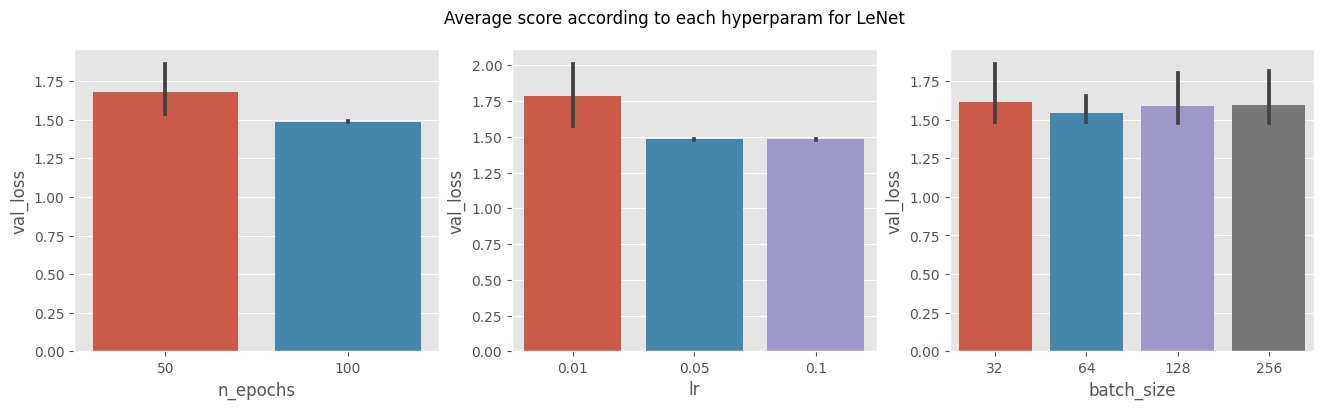

In [ ]:
# lr = [0.01, 0.05, 0.1]
# batch_size = [32, 64, 128, 256]
# num_epochs = [50, 100]
fig, axes = plt.subplots(1, 3, figsize=(16,4), dpi=100)
fig.suptitle('Average score according to each hyperparam for LeNet')
axes = iter(axes.reshape(-1))
for x, ax in zip(['n_epochs', 'lr', 'batch_size'], axes):
  sns.barplot(x=x, y='val_loss', data=final_scores[final_scores.net == 'LeNet'], ax=ax)

# final_scores[final_scores.net == 'BasicNet'].sort_values(by='val_acc')

In [ ]:
max_scores_ids = final_scores[['net', 'val_acc']].groupby('net').idxmax().values.reshape(-1)
top_nets = final_scores.loc[max_scores_ids, :].NetArch.values
final_scores.loc[max_scores_ids, :]

,epoch,train_acc,train_loss,val_acc,val_loss,elapsed_time,cuda,net,n_epochs,batch_size,lr,NetArch
6099,100,99.784127,1.463496,97.876190,1.483855,129.733026,yes,BasicNet,100,64,0.05,BasicNet_n=100_bs=64_lr=0.05
8099,100,99.520635,1.467812,98.619048,1.476486,124.744177,yes,LeNet,100,128,0.05,LeNet_n=100_bs=128_lr=0.05
2799,50,18.482540,2.276325,19.180952,2.269341,106.407989,yes,RegularizedComplexNet,50,256,0.01,RegularizedComplexNet_n=50_bs=256_lr=0.01


Text(0.5, 1.0, 'Validation loss')

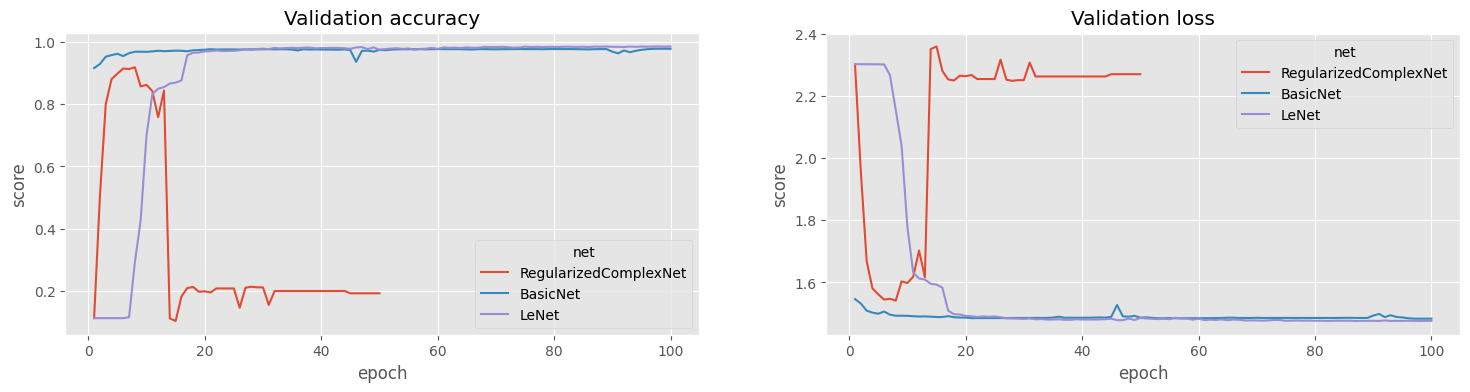

In [ ]:
# LeNet_n=100_bs=128_lr=0.05
top_results = results[results.NetArch.isin(top_nets)].copy()
melted_df = pd.melt(top_results, id_vars=['epoch', 'net'], value_vars=['train_loss', 'val_loss', 'val_acc'], var_name=['metric'], value_name='score')
melted_df

fig, axes = plt.subplots(1, 2, figsize=(18, 4), dpi=100)
sns.lineplot(x='epoch', y='score', hue='net', data=melted_df[melted_df.metric == 'val_acc'], ax=axes[0])
sns.lineplot(x='epoch', y='score', hue='net', data=melted_df[melted_df.metric == 'val_loss'], ax=axes[1])
axes[0].set_title('Validation accuracy')
axes[1].set_title('Validation loss')

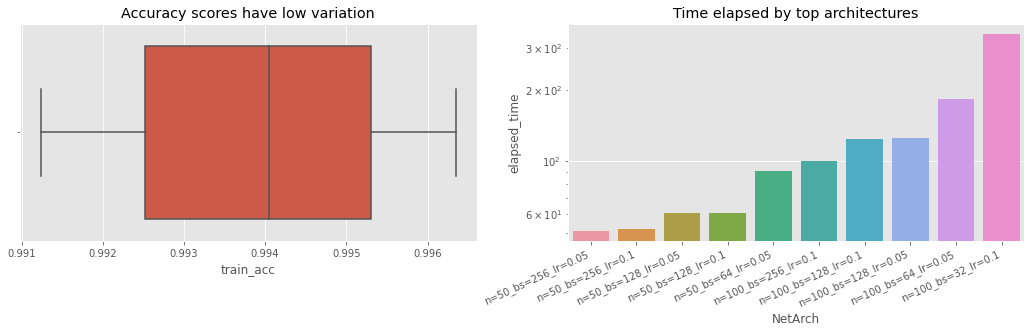

In [94]:
trade_off = final_scores[final_scores.net == 'LeNet'].nlargest(10, 'val_acc').copy()
trade_off.NetArch = trade_off.NetArch.apply(lambda x: x.split('LeNet_')[-1])
trade_off.sort_values(by='elapsed_time', inplace=True)
trade_off.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.boxplot(x='train_acc', data=trade_off, ax=ax[0])
# ax[0].set_xlim(.98,1)
ax[0].set_title('Accuracy scores have low variation')

sns.barplot(x='NetArch', y='elapsed_time', data=trade_off, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=25, ha='right')
ax[1].set_title('Time elapsed by top architectures')
ax[1].set_yscale('log')